# Amazon Deforestation Forecasting Using AI/ML and IoT Data
## Part II: Model Training and Evaluation
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 26, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [1]:
# !pip install torch
# !pip install pytorch-lightning
# !pip install pytorch-forecasting
!pip install pytorch-forecasting==1.0.0
!pip install pytorch-lightning==2.0.1.post0
!pip install torch==2.0.0
!pip install torchvision==0.15.1 torchaudio==2.0.1

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pytorch_forecasting import TimeSeriesDataSet
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load geo data layers from our data dir
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'

## Load the Prepared Dataset and Configure into TimeSeriesDataSet

Read in the dataset prepared in Stage I.  Load into TimeSeriesDataSet (input required by our TFT model).

In [50]:
# load in the prepared data
yearly_deforestation_df = pd.read_csv(root_dir + '/yearly_deforestation_merged_tft.csv')

In [7]:
# inspect
yearly_deforestation_df.head(20)

,Unnamed: 0,cluster,year,deforest_area_km,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start
0,0,-1,2008.0,708.026741,AC,1.707994e+08,113.339475,70.051073,0.000000e+00,0.000000,0.000000,0
1,1,-1,2009.0,199.543029,RO,2.377802e+08,1766.086970,23295.406781,0.000000e+00,0.000000,0.000000,1
2,2,-1,2010.0,313.131808,AM,1.589484e+09,51077.536558,48506.459703,0.000000e+00,0.000000,0.000000,2
3,3,-1,2011.0,190.866240,MT,5.130396e+08,1728.346000,45068.972799,0.000000e+00,0.000000,0.000000,3
4,4,-1,2012.0,96.429847,PA,1.238830e+09,44115.717775,66845.300030,0.000000e+00,0.000000,0.000000,4
5,5,-1,2013.0,126.674202,AM,1.589484e+09,51077.536558,48506.459703,0.000000e+00,0.000000,0.000000,5
6,6,-1,2014.0,121.737476,AM,1.589484e+09,51077.536558,48506.459703,0.000000e+00,0.000000,0.000000,6
7,7,-1,2015.0,139.550549,PA,1.238830e+09,44115.717775,66845.300030,0.000000e+00,0.000000,0.000000,7
8,8,-1,2016.0,150.172549,RR,2.253429e+08,1753.155361,60902.109316,0.000000e+00,0.000000,0.000000,8
9,9,-1,2017.0,208.391069,MA,1.137373e+08,4818.959857,8166.208790,0.000000e+00,0.000000,0.000000,9


In [51]:
# remove null category
yearly_deforestation_df = yearly_deforestation_df[yearly_deforestation_df["cluster"] != -1]

In [52]:
# create a string column (categorical) for cluster - required by TimeSeriesDataset/Model
yearly_deforestation_df["cluster_name"] = yearly_deforestation_df["cluster"].apply(lambda x: "cl_" + str(x))

In [10]:
# inspect results
yearly_deforestation_df.sample(10)

,Unnamed: 0,cluster,year,deforest_area_km,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start,cluster_name
14246,14246,1679,2008.0,0.536683,MT,5.130396e+08,1728.346000,45068.972799,2.564318e+04,0.000000,0.000000,0,cl_1679
4369,4369,396,2021.0,0.085847,MA,1.137373e+08,4818.959857,8166.208790,1.273711e+04,0.000000,0.000000,13,cl_396
16340,16340,2104,2022.0,0.550713,PA,1.238830e+09,44115.717775,66845.300030,2.857577e+03,0.000000,0.000000,14,cl_2104
10835,10835,1160,2016.0,0.063540,PA,1.238830e+09,44115.717775,66845.300030,8.839536e+02,0.000000,0.000000,8,cl_1160
2089,2089,178,2010.0,10.418196,MT,5.130396e+08,1728.346000,45068.972799,1.717838e+06,14775.560443,2393.311018,2,cl_178
14865,14865,1789,2010.0,0.066632,RO,2.377802e+08,1766.086970,23295.406781,6.175796e+03,0.000000,0.000000,2,cl_1789
5366,5366,509,2011.0,0.595208,MT,5.130396e+08,1728.346000,45068.972799,3.747961e+05,141274.042285,0.000000,3,cl_509
7640,7640,752,2017.0,0.199072,PA,1.238830e+09,44115.717775,66845.300030,4.905824e+03,0.000000,0.000000,9,cl_752
10535,10535,1121,2018.0,0.146700,PA,1.238830e+09,44115.717775,66845.300030,2.102486e+04,856.828781,154.126192,10,cl_1121
9718,9718,1016,2012.0,0.213545,PA,1.238830e+09,44115.717775,66845.300030,1.659428e+05,0.000000,0.000000,4,cl_1016


In [53]:
# drop clusters that do not have enough time history
clusters = yearly_deforestation_df["cluster_name"].unique()
for cluster in clusters:
    cluster_year = yearly_deforestation_df[yearly_deforestation_df["cluster_name"] == cluster]
    # we need to give our model at least 10 years of readings
    if(len(cluster_year) <= 6):
        yearly_deforestation_df = yearly_deforestation_df[yearly_deforestation_df["cluster_name"] != cluster]


In [54]:
# check how many clusters we have left
len(yearly_deforestation_df["cluster_name"].unique())

1141

In [33]:
yearly_deforestation_df[yearly_deforestation_df["cluster_name"] == "cl_2104"]

,Unnamed: 0,cluster,year,deforest_area_km,state,state_area,state_hydro_area,state_no_forest_area,cluster_area,cluster_no_forest_area,cluster_hydro_area,years_from_start,cluster_name


In [78]:
yearly_deforestation_df["years_from_start"].max()

14

### Create Train and Validation Datasets
Load dataframe into TimeSeriesDataSet and split at prediction horizon (3 years) for train/test

In [79]:
# setup parameters
max_prediction_length = 3
max_encoder_length = 14
min_encoder_length = 3

# training cutoff keeps series up to certain year
training_cutoff = yearly_deforestation_df["years_from_start"].max() - max_prediction_length + 1

# define training dataset
training = TimeSeriesDataSet(
    yearly_deforestation_df[lambda x: x.years_from_start <= training_cutoff],
    time_idx="years_from_start",
    target="deforest_area_km",
    group_ids=["cluster_name"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["cluster_name", "state"],
    static_reals=["state_area", "state_hydro_area", "state_no_forest_area", "cluster_area", "cluster_no_forest_area", "cluster_hydro_area"],
    time_varying_known_reals=["year"],
    time_varying_unknown_reals=["deforest_area_km"],
    target_normalizer=GroupNormalizer(
        groups=["cluster_name"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# define test dataset
validation = TimeSeriesDataSet.from_dataset(training, yearly_deforestation_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64

# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


## Experiment 1: Train TFT Model to predict new deforestation area by year for each cluster



In [81]:
# setup model and trainer parameters
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=8,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [82]:
# train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 93.6 K
3  | prescalers                         | ModuleDict                      | 3.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 951 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 313 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 208 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.354
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.354


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.159 >= min_delta = 0.0001. New best score: 2.195
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.159 >= min_delta = 0.0001. New best score: 2.195


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.161 >= min_delta = 0.0001. New best score: 2.033
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.161 >= min_delta = 0.0001. New best score: 2.033


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.098 >= min_delta = 0.0001. New best score: 1.935
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.098 >= min_delta = 0.0001. New best score: 1.935


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 1.932
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 1.932


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 1.932. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.932. Signaling Trainer to stop.


In [83]:
# get best model
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_15/checkpoints/epoch=10-step=2453.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [84]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


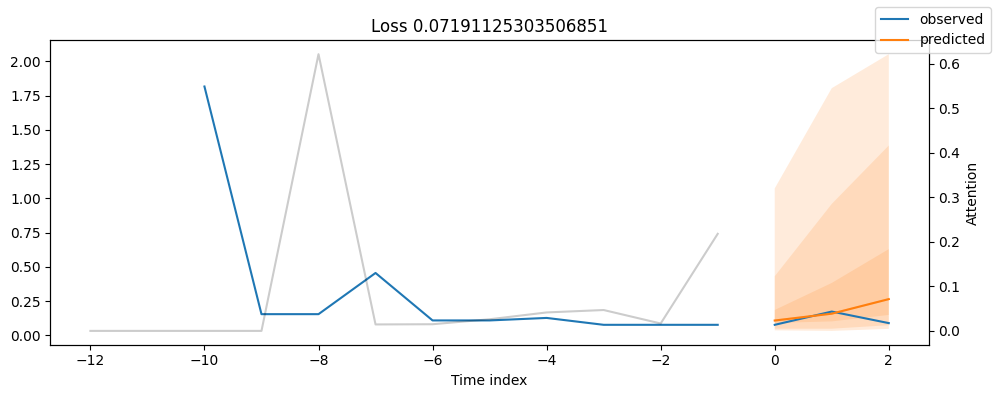

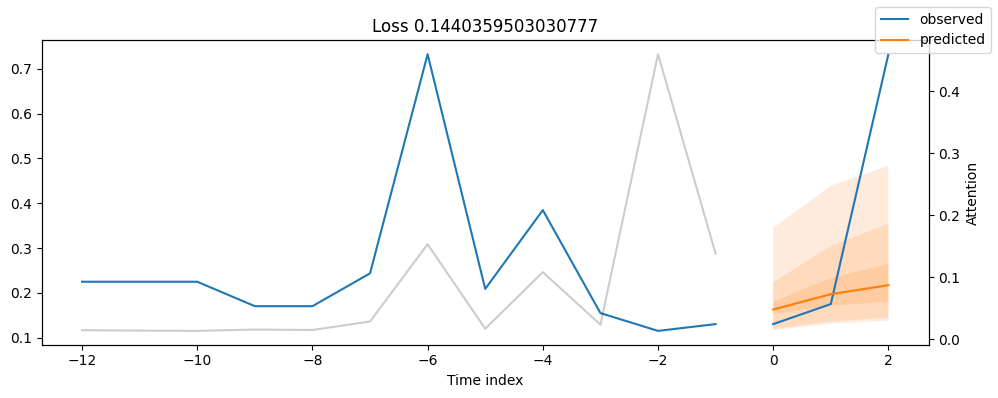

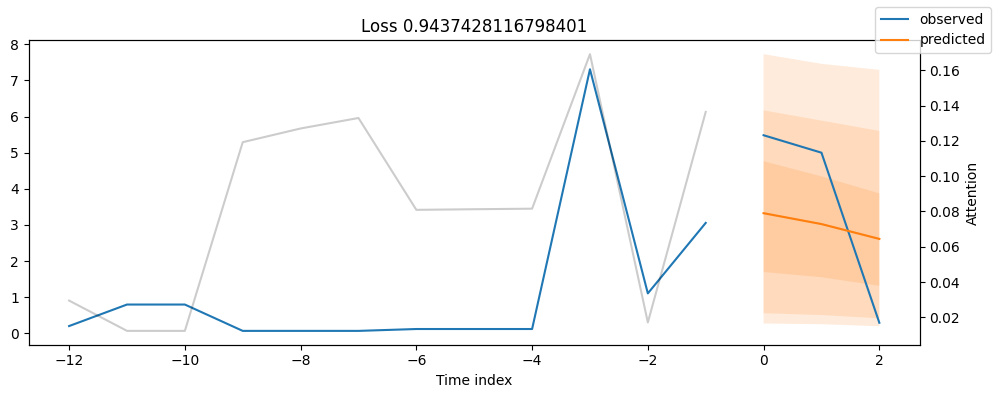

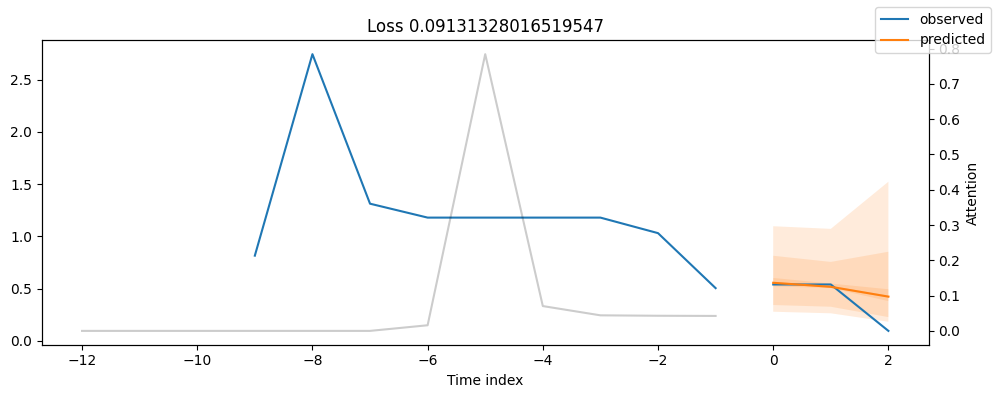

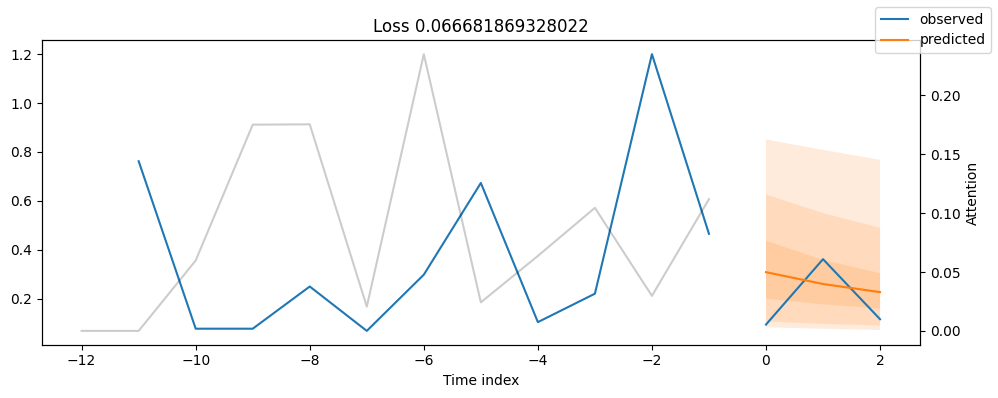

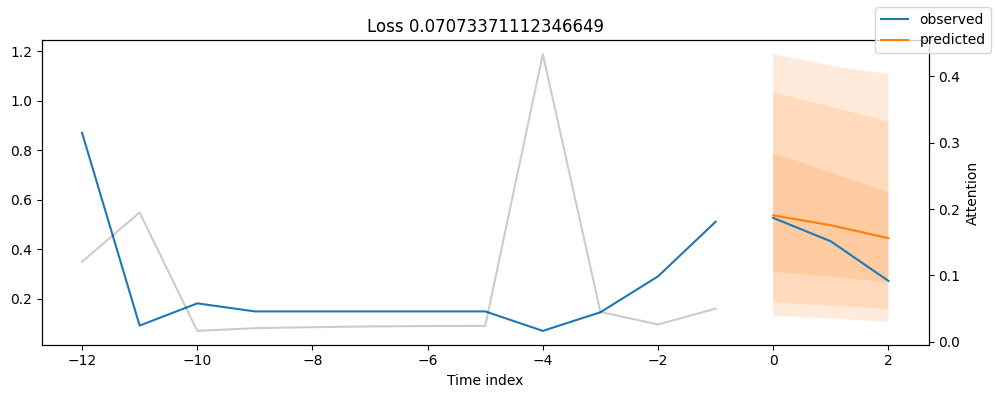

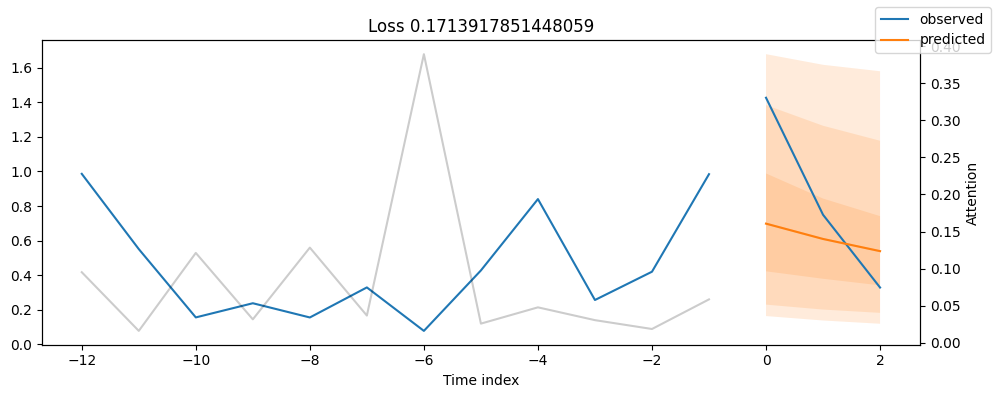

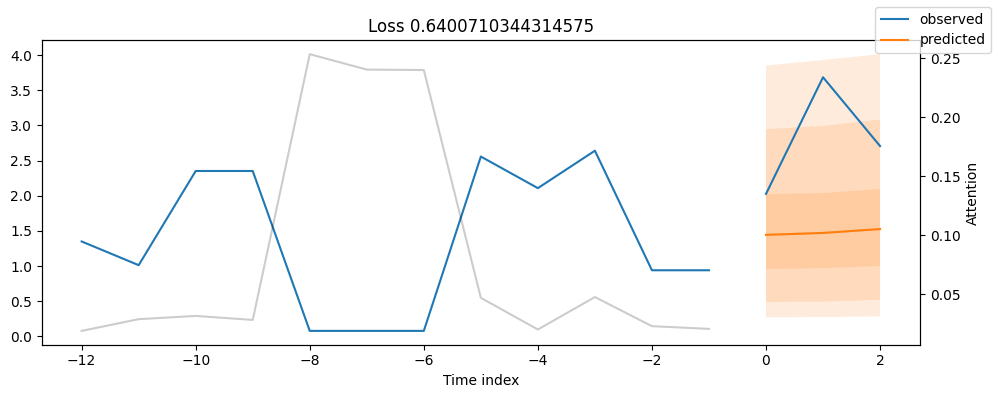

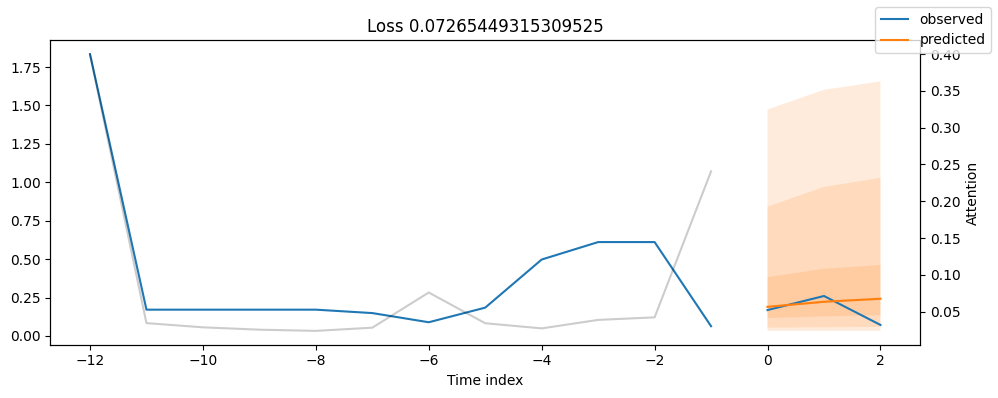

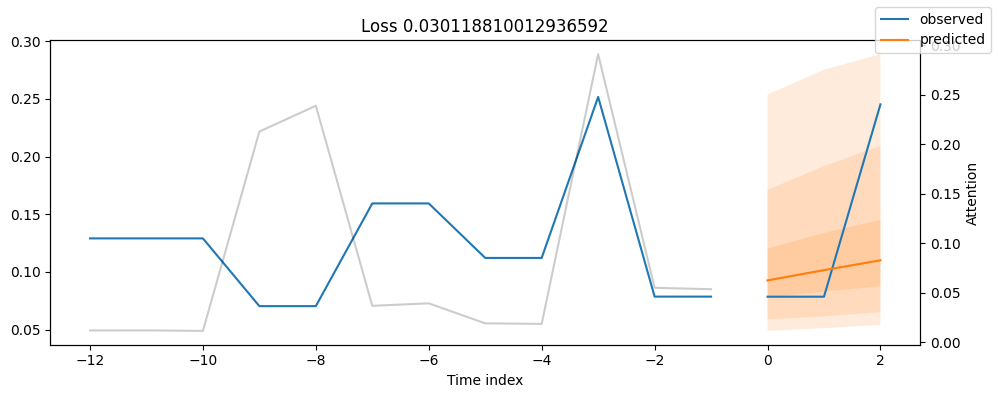

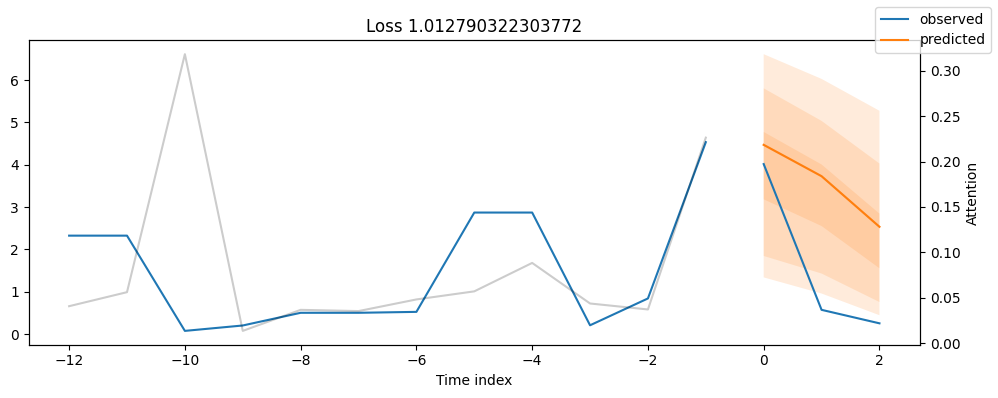

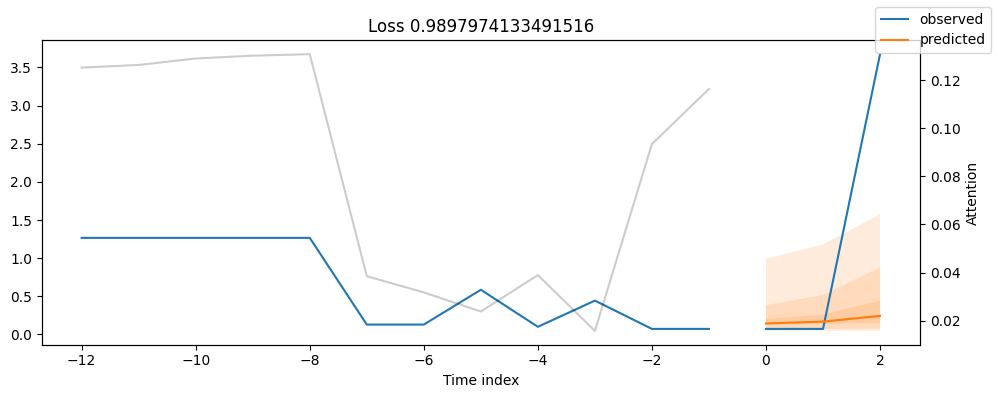

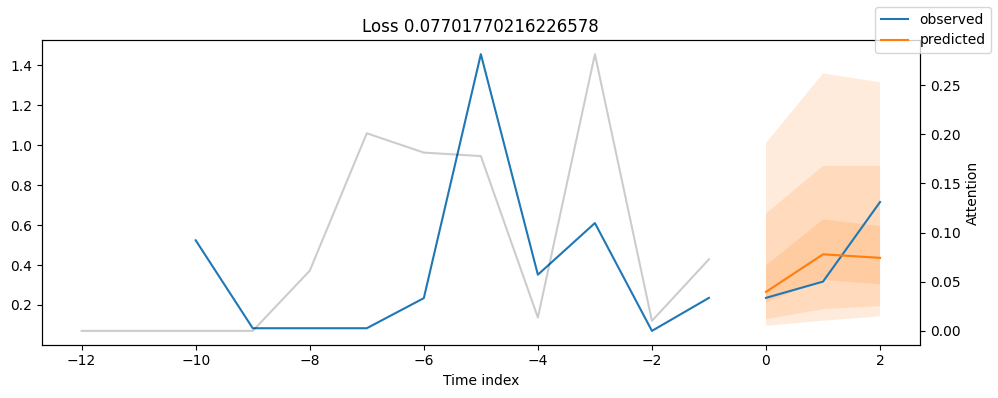

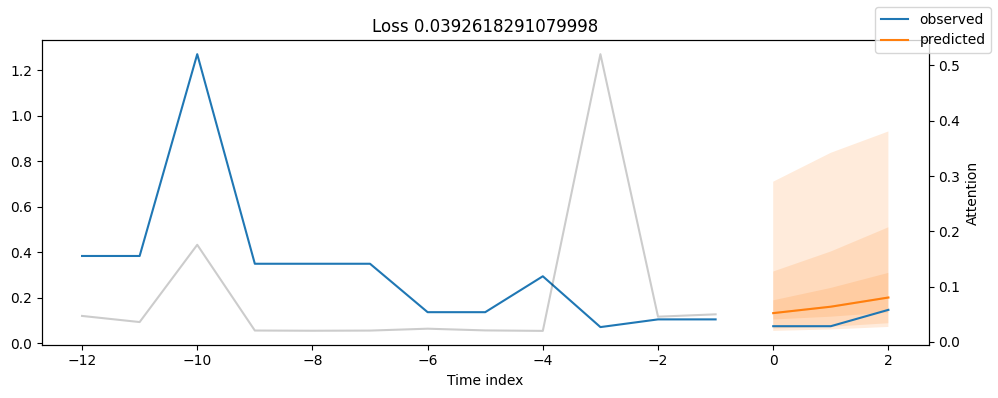

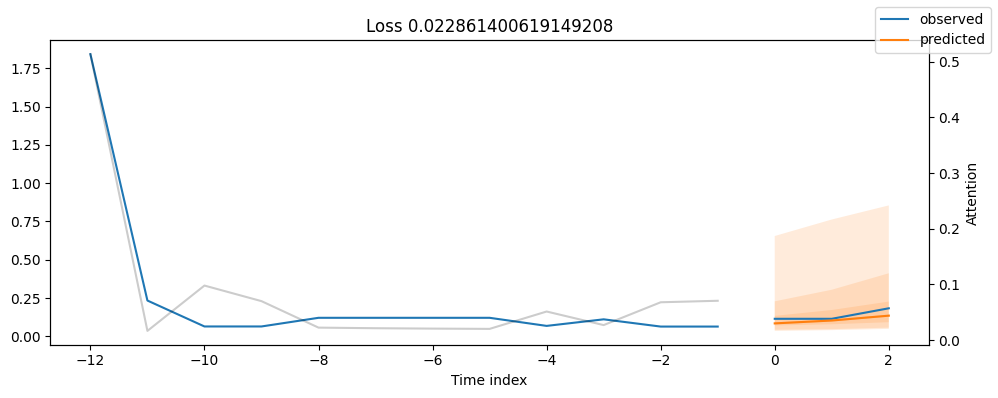

In [85]:
for idx in range(150, 165):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
